In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [25]:
import numpy as np
import os
import cv2
import pandas as pd
from torch.utils.data import Dataset


def bbox(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    return rmin, rmax, cmin, cmax


def crop(image):
    ymin,ymax,xmin,xmax = bbox(image > 0.5)
    return image[ymin:ymax, xmin:xmax]


class ProxyTask(Dataset):
    def __init__(self, csv_file, transform):
        df = pd.read_csv(csv_file)
        df["slice_idx"] = df["image"].apply(lambda x: int(x.split("/")[-1].split(".")[1]))
        df["max_slice_idx"] = df.groupby("patient_id")["slice_idx"].transform("max")
        df["min_slice_idx"] = df.groupby("patient_id")["slice_idx"].transform("min")
        self.images = df["image"].values
        self.patient_ids = df["patient_id"].values
        self.max_slice_idxs = df["max_slice_idx"].values
        self.min_slice_idxs = df["min_slice_idx"].values
        self.slice_idxs = df["slice_idx"].values

        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = "../" + self.images[idx]
        print(image_path)
        patient_id = self.patient_ids[idx]
        max_slice_idx = self.max_slice_idxs[idx]
        min_slice_idx = self.min_slice_idxs[idx]
        slice_idx = self.slice_idxs[idx]

        if slice_idx == min_slice_idx:
            rnd_temporal_idx = 0
        elif slice_idx == min_slice_idx + 1:
            rnd_temporal_idx = np.random.choice([-1, 0], size=1)[0]
        elif slice_idx == max_slice_idx:
            rnd_temporal_idx = 0
        elif slice_idx == max_slice_idx - 1:
            rnd_temporal_idx = np.random.choice([0, 1], size=1)[0]
        else:
            rnd_temporal_idx = np.random.choice([-2, -1, 0, 1, 2], size=1)[0]

        mix_idx = slice_idx + rnd_temporal_idx
        image = np.load(image_path)
        if mix_idx == slice_idx: # No mix
            label = rnd_temporal_idx + 2
            ymin, ymax, xmin, xmax = bbox(image > 0.5)
            image = image[ymin:350, xmin:xmax]
        else:
            mix_image_path = image_path.replace(f".{slice_idx}.", f".{mix_idx}.")
            mix_image = np.load(mix_image_path)

            cutout_size = 25

            ymin, ymax, xmin, xmax = bbox(image > 0.5)
            for i in range(20):
                ystart = np.random.randint(ymin, 350 - cutout_size)
                xstart = np.random.randint(xmin, xmax - cutout_size)
                # mix a part of two images
                image[ystart:ystart + cutout_size, xstart:xstart + cutout_size] = mix_image[ystart:ystart + cutout_size, xstart:xstart + cutout_size]
            image = image[ymin:350, xmin:xmax]
            label = rnd_temporal_idx + 2

        image = np.stack((image, image, image), axis=-1)

        if self.transform:
            image = self.transform(image=image)["image"]
            image = np.transpose(image, (2, 0, 1)).astype(np.float32)


        return {
            "images": image,
            "targets": label
        }

In [26]:
dataset = ProxyTask(csv_file="../data/Thoracic_OAR_2d/data.csv", transform=None)

..//data/Thoracic_OAR_2d/13/image.30.npy
0


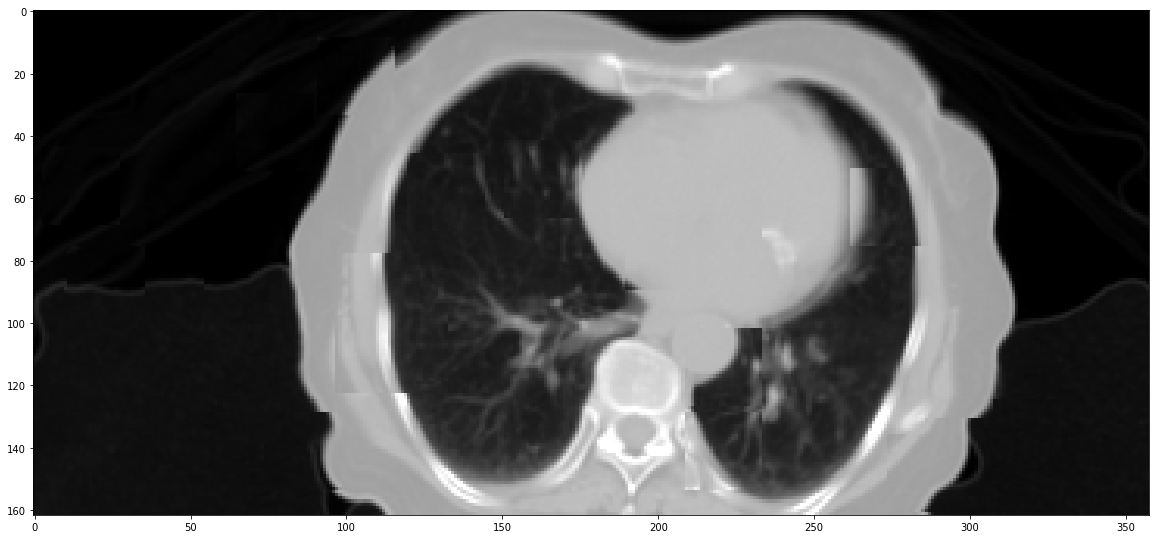

In [27]:
ret = dataset[30]
print(ret["targets"])
plt.figure(figsize=(20, 20))
plt.imshow(ret["images"])

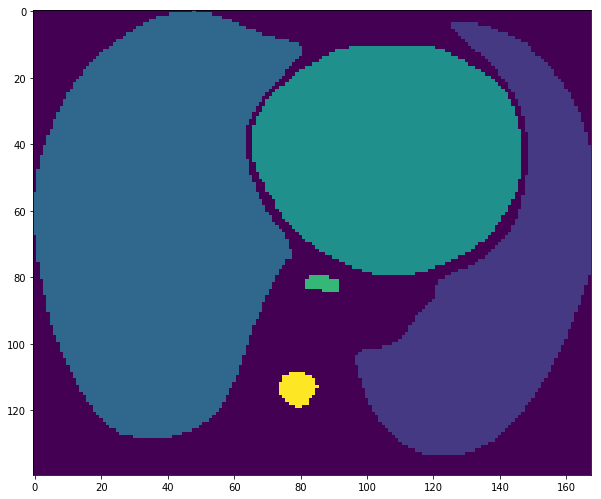

In [38]:
i = np.load("..//data/Thoracic_OAR_2d/13/mask.32.npy")
ymin, ymax, xmin, xmax = bbox(i > 0.5)
i = i[ymin:350, xmin:xmax]
# i = np.stack((i, i, i), axis=-1)
plt.figure(figsize=(10, 10))
plt.imshow(i)

In [ ]:
import SimpleITK
import SimpleITK as sitk

In [ ]:
def load_ct_images(path):
    image = SimpleITK.ReadImage(path)
    image = SimpleITK.GetArrayFromImage(image).astype(np.float32)
    return image

In [ ]:
image = load_ct_images("./data/lits/nas/01_Datasets/CT/LITS/Training_Batch_2/volume-116.nii")

In [ ]:
plt.imshow(image[0])

In [ ]:
plt.imshow(image[500])